# <center style='color:dodgerblue'>`Conditional DDPM` using PyTorch - Example with `MNIST` Dataset</center>

# 1. Import required libraries

In [1]:
import torch
print('PyTorch version:', torch.__version__)
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

import torchvision
print('Torchvision version:', torchvision.__version__)
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import make_grid

from tqdm import tqdm
from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt

PyTorch version: 2.0.1+cu117
Torchvision version: 0.15.2+cu117


# 2. Define the device

In [2]:
print('GPU name:', torch.cuda.get_device_name(), '\n')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device is:', device, '\n')
print('Total number of GPUs:', torch.cuda.device_count())

GPU name: NVIDIA RTX A5000 

Device is: cuda 

Total number of GPUs: 1


# 3. Load `MNIST` dataset

In [3]:
transform = transforms.Compose([transforms.Resize((32, 32)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,), std=(0.5,))])

In [4]:
training_dataset = datasets.MNIST(root='./data_src', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data_src', train=False, download=True, transform=transform)

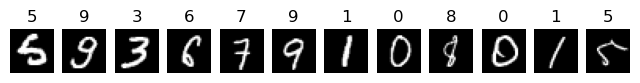

In [5]:
# show 12 randomly selected samples from the training dataset

fig, axis = plt.subplots(nrows=1, ncols=12, figsize=(8, 1))

for ax, _ in zip(axis.ravel(), range(12)):
    inx = np.random.randint(len(training_dataset))
    ax.imshow(training_dataset.data[inx], cmap='gray')
    ax.set_title(int(training_dataset.targets[inx]), fontsize=12)
    ax.axis(False);

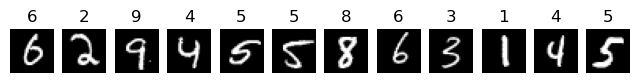

In [6]:
# show 12 randomly selected samples from the test dataset

fig, axis = plt.subplots(nrows=1, ncols=12, figsize=(8, 1))

for ax, _ in zip(axis.ravel(), range(12)):
    inx = np.random.randint(len(test_dataset))
    ax.imshow(test_dataset.data[inx], cmap='gray')
    ax.set_title(int(test_dataset.targets[inx]), fontsize=12)
    ax.axis(False);

# 4. Define dataloaders 

In [7]:
training_dataloader = DataLoader(training_dataset, batch_size=64, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=True)

# 5. Define `Linear_Variance_Scheduler` for `Conditional_DDPM`

In [8]:
class Linear_Variance_Scheduler:
    def __init__(self, time_steps, beta_start, beta_end, device='cuda'):
        
        self.time_steps = time_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.device = device
        
        self.betas = torch.linspace(self.beta_start, self.beta_end, self.time_steps).to(self.device)
        self.alphas = 1 - self.betas
        self.alpha_bar = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alpha_bar = torch.sqrt(self.alpha_bar)
        self.sqrt_one_minus_alpha_bar = torch.sqrt(1 - self.alpha_bar)
        
    def diffusion_process(self, x, noise, t):
        sqrt_alpha_bar = self.sqrt_alpha_bar[t][:, None, None, None]
        sqrt_one_minus_alpha_bar = self.sqrt_one_minus_alpha_bar[t][:, None, None, None]
        return sqrt_alpha_bar * x + sqrt_one_minus_alpha_bar * noise
    
    def ddpm_sampling(self, model, num_samples, channels, img_size, labels): #
        model.eval()
        with torch.inference_mode():
            x = torch.randn((num_samples, channels, img_size, img_size)).to(self.device)
            collect = []
            for i in tqdm(reversed(range(self.time_steps))):
                t = (torch.ones(num_samples) * i).long().to(self.device)
                pred_noise = model(x, t, labels) #
                alphas = self.alphas[t][:, None, None, None]
                alpha_bar = self.alpha_bar[t][:, None, None, None]
                betas = self.betas[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alphas) * (x - ((1 - alphas) / (torch.sqrt(1 - alpha_bar))) * pred_noise) +\
                    torch.sqrt(betas) * noise
                if (i+1) % 100 == 0 or i==0:
                    collect.append(x)
        return x, collect

# 6. Forward process output

In [9]:
t_step = torch.linspace(start=0, end=1000-1, steps=11).long()
get_img = training_dataset[0][0]
print('Image label:', training_dataset[0][1])
get_img_stack = torch.stack([get_img]*11)
get_noise_stack = torch.randn_like(get_img_stack)

Image label: 5


In [10]:
noisy_img_stack = Linear_Variance_Scheduler(time_steps=1000, beta_start=0.0001, beta_end=0.02,
                                            device='cpu').diffusion_process(get_img_stack, get_noise_stack, t_step)

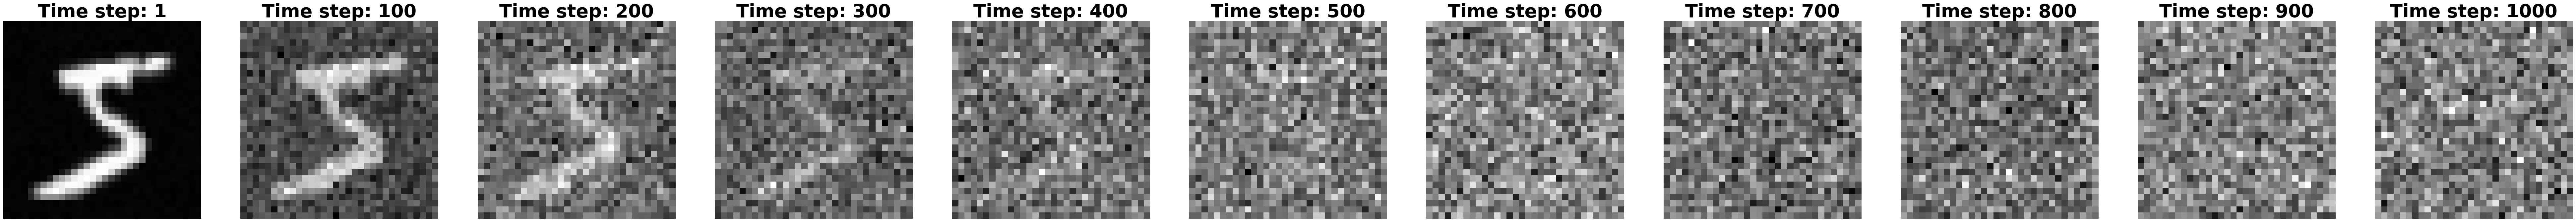

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=11, figsize=(100, 100))

for idx, img in enumerate(noisy_img_stack):
    ax[idx].imshow(img.squeeze(), cmap='gray')
    ax[idx].set_title(f'Time step: {t_step[idx]+1}', fontsize=40, fontweight='bold')
    ax[idx].axis(False);

# 7. Create `ResBlock`

In [12]:
class ResBlock(nn.Module):
    def __init__(self, inp_ch, out_ch, mid_ch=None, residual=False):
        super(ResBlock, self).__init__()
        
        self.residual = residual
        if not mid_ch:
            mid_ch = out_ch
        self.resnet_conv = nn.Sequential()
        self.resnet_conv.add_module('conv1', nn.Conv2d(in_channels=inp_ch, out_channels=mid_ch, kernel_size=3, stride=1,
                                                       padding=1))
        self.resnet_conv.add_module('gnor1', nn.GroupNorm(num_groups=8, num_channels=mid_ch))
        self.resnet_conv.add_module('silu1', nn.SiLU())
        self.resnet_conv.add_module('conv2', nn.Conv2d(in_channels=mid_ch, out_channels=out_ch, kernel_size=3, stride=1,
                                                       padding=1))
        self.resnet_conv.add_module('gnor2', nn.GroupNorm(num_groups=8, num_channels=out_ch))
        
    def forward(self, x):
        if self.residual:
            return x + self.resnet_conv(x)
        else:
            return self.resnet_conv(x)

# 8. Create `SelfAttentionBlock`

In [13]:
class SelfAttentionBlock(nn.Module):
    def __init__(self, channels):
        super(SelfAttentionBlock, self).__init__()
        
        self.attn_norm = nn.GroupNorm(num_groups=8, num_channels=channels)
        self.mha = nn.MultiheadAttention(embed_dim=channels, num_heads=4, batch_first=True)
        
    def forward(self, x):
        b, c, h, w = x.shape
        inp_attn = x.reshape(b, c, h*w)
        inp_attn = self.attn_norm(inp_attn)
        inp_attn = inp_attn.transpose(1, 2)
        out_attn, _ = self.mha(inp_attn, inp_attn, inp_attn)
        out_attn = out_attn.transpose(1, 2).reshape(b, c, h, w)
        return x + out_attn

# 9. Create `DownBlock`

In [14]:
class DownBlock(nn.Module):
    def __init__(self, inp_ch, out_ch, t_emb_dim=256):
        super(DownBlock, self).__init__()
        
        self.down = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResBlock(inp_ch=inp_ch, out_ch=inp_ch, residual=True),
            ResBlock(inp_ch=inp_ch, out_ch=out_ch)
        )
        
        self.t_emb_layers = nn.Sequential()
        self.t_emb_layers.add_module('silu1', nn.SiLU())
        self.t_emb_layers.add_module('linr1', nn.Linear(in_features=t_emb_dim, out_features=out_ch))
        
    def forward(self, x, t):
        x = self.down(x)
        t_emb = self.t_emb_layers(t)[:, :, None, None].repeat(1, 1, x.shape[2], x.shape[3])
        return x + t_emb

# 10. Create `UpBlock`

In [15]:
class UpBlock(nn.Module):
    def __init__(self, inp_ch, out_ch, t_emb_dim=256):
        super(UpBlock, self).__init__()
        
        self.upsamp = nn.UpsamplingBilinear2d(scale_factor=2)
        self.up = nn.Sequential(
            ResBlock(inp_ch=inp_ch, out_ch=inp_ch, residual=True),
            ResBlock(inp_ch=inp_ch, out_ch=out_ch, mid_ch=inp_ch//2)
        )
        
        self.t_emb_layers = nn.Sequential()
        self.t_emb_layers.add_module('silu1', nn.SiLU())
        self.t_emb_layers.add_module('linr1', nn.Linear(in_features=t_emb_dim, out_features=out_ch))
        
    def forward(self, x, skip, t):
        x = self.upsamp(x)
        x = torch.cat([skip, x], dim=1)
        x = self.up(x)
        t_emb = self.t_emb_layers(t)[:, :, None, None].repeat(1, 1, x.shape[2], x.shape[3])
        return x + t_emb

# 11. Create `Conditional_UNet` architecture

In [16]:
class Conditional_UNet(nn.Module):
    def __init__(self, t_emb_dim, n_classes, device='cuda'): #
        super(Conditional_UNet, self).__init__()
        
        self.device = device
        self.t_emb_dim = t_emb_dim
        #
        self.n_classes = n_classes
        
        self.inp = ResBlock(inp_ch=1, out_ch=64)
        self.down1 = DownBlock(inp_ch=64, out_ch=128)
        self.sa1 = SelfAttentionBlock(channels=128)
        self.down2 = DownBlock(inp_ch=128, out_ch=256)
        self.sa2 = SelfAttentionBlock(channels=256)
        self.down3 = DownBlock(inp_ch=256, out_ch=256)
        self.sa3 = SelfAttentionBlock(channels=256)
        
        self.lat1 = ResBlock(inp_ch=256, out_ch=512)
        self.lat2 = ResBlock(inp_ch=512, out_ch=512)
        self.lat3 = ResBlock(inp_ch=512, out_ch=256)
        
        self.up1 = UpBlock(inp_ch=512, out_ch=128)
        self.sa4 = SelfAttentionBlock(channels=128)
        self.up2 = UpBlock(inp_ch=256, out_ch=64)
        self.sa5 = SelfAttentionBlock(channels=64)
        self.up3 = UpBlock(inp_ch=128, out_ch=64)
        self.sa6 = SelfAttentionBlock(channels=64)
        
        self.out = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)
        #
        self.embeddings = nn.Embedding(num_embeddings=self.n_classes, embedding_dim=self.t_emb_dim)
        
    def position_embeddings(self, t, channels):
        i = 1 / (10000 ** (torch.arange(start=0, end=channels, step=2, device=self.device) / channels))
        pos_emb_sin = torch.sin(t.repeat(1, channels//2) * i)
        pos_emb_cos = torch.cos(t.repeat(1, channels//2) * i)
        pos_emb = torch.cat([pos_emb_sin, pos_emb_cos], dim=-1)
        return pos_emb
    
    def forward(self, x, t, labels): #
        t = t.unsqueeze(1).float()
        t = self.position_embeddings(t, self.t_emb_dim)
        #
        t += self.embeddings(labels)
        
        x1 = self.inp(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)
        
        x4 = self.lat1(x4)
        x4 = self.lat2(x4)
        x4 = self.lat3(x4)
        
        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.out(x)
        return output

# 12. Visualize `Conditional_UNet` architecture

In [17]:
summary(Conditional_UNet(t_emb_dim=256, n_classes=10), input_size=[(64, 1, 32, 32), (64,), (64,)],
        dtypes=[torch.float, torch.float, torch.long]) #

Layer (type:depth-idx)                        Output Shape              Param #
Conditional_UNet                              [64, 1, 32, 32]           --
├─Embedding: 1-1                              [64, 256]                 2,560
├─ResBlock: 1-2                               [64, 64, 32, 32]          --
│    └─Sequential: 2-1                        [64, 64, 32, 32]          --
│    │    └─Conv2d: 3-1                       [64, 64, 32, 32]          640
│    │    └─GroupNorm: 3-2                    [64, 64, 32, 32]          128
│    │    └─SiLU: 3-3                         [64, 64, 32, 32]          --
│    │    └─Conv2d: 3-4                       [64, 64, 32, 32]          36,928
│    │    └─GroupNorm: 3-5                    [64, 64, 32, 32]          128
├─DownBlock: 1-3                              [64, 128, 16, 16]         --
│    └─Sequential: 2-2                        [64, 128, 16, 16]         --
│    │    └─MaxPool2d: 3-6                    [64, 64, 16, 16]          --
│    │    

# 13. Set up `Linear_Variance_Scheduler`, model (`Conditional_UNet`), criterion (`loss_function`) and optimizer

In [18]:
ddpm = Linear_Variance_Scheduler(time_steps=1000, beta_start=0.0001, beta_end=0.02)
model = Conditional_UNet(t_emb_dim=256, n_classes=10).to(device) #
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 14. Train `Conditional_DDPM`

In [19]:
torch.manual_seed(1111)
torch.random.manual_seed(1111)
torch.cuda.manual_seed(1111)
torch.cuda.manual_seed_all(1111)
np.random.seed(1111)

n_epochs = 20
training_loss, test_loss = [], []

for epoch in range(n_epochs):
    training_losses, test_losses = [], []
    
    for data, labels in tqdm(training_dataloader): #
        model.train()
        data = data.to(device)
        #
        labels = labels.to(device)
        t = torch.randint(low=0, high=1000, size=(data.shape[0],)).to(device)
        noise = torch.randn_like(data)
        xt = ddpm.diffusion_process(x=data, noise=noise, t=t)
        pred_noise = model(xt, t, labels) #
        trng_batch_loss = criterion(noise, pred_noise)
        optimizer.zero_grad()
        trng_batch_loss.backward()
        optimizer.step()
        training_losses.append(trng_batch_loss.item())
    training_per_epoch_loss = np.array(training_losses).mean()
    
    with torch.inference_mode():
        for data, labels in tqdm(test_dataloader): #
            model.eval()
            data = data.to(device)
            #
            labels = labels.to(device)
            t = torch.randint(low=0, high=1000, size=(data.shape[0],)).to(device)
            noise = torch.randn_like(data)
            xt = ddpm.diffusion_process(x=data, noise=noise, t=t)
            pred_noise = model(xt, t, labels) #
            tst_batch_loss = criterion(noise, pred_noise)
            test_losses.append(tst_batch_loss.item())
        test_per_epoch_loss = np.array(test_losses).mean()
        
    training_loss.append(training_per_epoch_loss)
    test_loss.append(test_per_epoch_loss)
    
    print(f'Epoch: {epoch+1}/{n_epochs}\t| Training loss: {training_per_epoch_loss:.4f} |    ', end='')
    print(f'Test loss: {test_per_epoch_loss:.4f}')

100%|█████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 25.02it/s]


Epoch: 1/20	| Training loss: 0.0546 |    Test loss: 0.0293


100%|█████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 25.01it/s]


Epoch: 2/20	| Training loss: 0.0266 |    Test loss: 0.0252


100%|█████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 25.06it/s]


Epoch: 3/20	| Training loss: 0.0227 |    Test loss: 0.0216


100%|█████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 25.00it/s]


Epoch: 4/20	| Training loss: 0.0208 |    Test loss: 0.0193


100%|█████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 25.06it/s]


Epoch: 5/20	| Training loss: 0.0193 |    Test loss: 0.0190


100%|█████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 25.01it/s]


Epoch: 6/20	| Training loss: 0.0185 |    Test loss: 0.0183


100%|█████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 25.03it/s]


Epoch: 7/20	| Training loss: 0.0181 |    Test loss: 0.0176


100%|█████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 25.05it/s]


Epoch: 8/20	| Training loss: 0.0175 |    Test loss: 0.0168


100%|█████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 25.01it/s]


Epoch: 9/20	| Training loss: 0.0172 |    Test loss: 0.0172


100%|█████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 25.05it/s]


Epoch: 10/20	| Training loss: 0.0168 |    Test loss: 0.0166


100%|█████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 25.02it/s]


Epoch: 11/20	| Training loss: 0.0168 |    Test loss: 0.0170


100%|█████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 25.03it/s]


Epoch: 12/20	| Training loss: 0.0165 |    Test loss: 0.0161


100%|█████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 25.01it/s]


Epoch: 13/20	| Training loss: 0.0162 |    Test loss: 0.0160


100%|█████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 25.04it/s]


Epoch: 14/20	| Training loss: 0.0160 |    Test loss: 0.0157


100%|█████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 24.99it/s]


Epoch: 15/20	| Training loss: 0.0162 |    Test loss: 0.0156


100%|█████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 25.01it/s]


Epoch: 16/20	| Training loss: 0.0158 |    Test loss: 0.0156


100%|█████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 25.02it/s]


Epoch: 17/20	| Training loss: 0.0156 |    Test loss: 0.0155


100%|█████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 25.01it/s]


Epoch: 18/20	| Training loss: 0.0156 |    Test loss: 0.0154


100%|█████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 25.02it/s]


Epoch: 19/20	| Training loss: 0.0157 |    Test loss: 0.0152


100%|█████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 25.00it/s]

Epoch: 20/20	| Training loss: 0.0153 |    Test loss: 0.0154


# 15. Plot losses

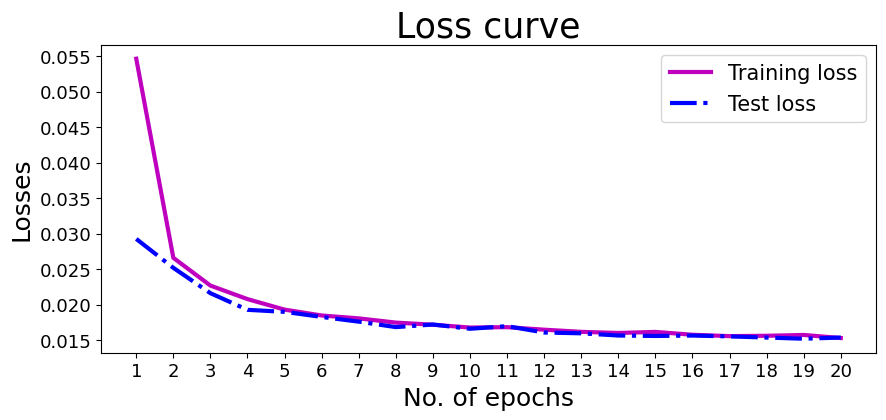

In [20]:
N = np.arange(n_epochs) + 1

plt.figure(figsize=(10, 4))
plt.plot(N, training_loss, 'm-', linewidth=3, label='Training loss')
plt.plot(N, test_loss, 'b-.', linewidth=3, label='Test loss')
plt.title('Loss curve', fontsize=25)
plt.xlabel('No. of epochs', fontsize=18)
plt.ylabel('Losses', fontsize=18)
plt.xticks(N, fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=15);

# 16. Reverse process output conditioned on label

In [21]:
#
y = torch.randint(low=0, high=10, size=(1,)).to(device)
print('Generating the image of:\n', y)

Generating the image of:
 tensor([9], device='cuda:0')


In [22]:
_, collect = ddpm.ddpm_sampling(model=model, num_samples=1, channels=1, img_size=32, labels=y) #

1000it [00:03, 275.88it/s]


In [23]:
step = [1000, 900, 800, 700, 600, 500, 400, 300, 200, 100, 1]

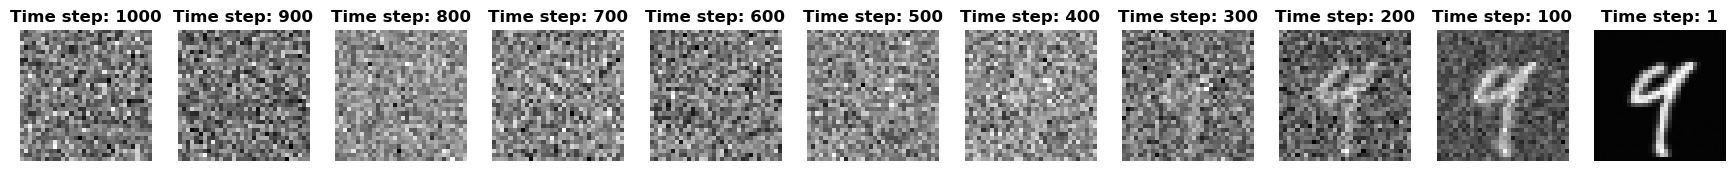

In [24]:
fig, axis = plt.subplots(nrows=1, ncols=11, figsize=(22, 2))

j = 0
for ax, _ in zip(axis.ravel(), range(11)):
    ax.imshow(collect[j][0].detach().cpu().permute(1, 2, 0), cmap='gray')
    ax.set_title(f'Time step: {step[j]}', fontweight='bold')
    ax.axis(False)
    j += 1;

# 17. Random sampling from noise conditioned on labels

In [25]:
#
Y = torch.randint(low=0, high=10, size=(64,)).to(device)
print('Generating the images of:\n', Y)

Generating the images of:
 tensor([7, 4, 1, 0, 0, 1, 4, 0, 0, 9, 3, 8, 1, 4, 9, 2, 2, 1, 2, 9, 2, 5, 6, 1,
        9, 2, 4, 5, 3, 6, 4, 2, 8, 1, 8, 0, 8, 3, 4, 8, 4, 9, 9, 2, 2, 0, 8, 1,
        6, 6, 6, 7, 3, 7, 1, 2, 7, 3, 5, 5, 5, 3, 6, 2], device='cuda:0')


In [26]:
sampled_imgs, _ = ddpm.ddpm_sampling(model=model, num_samples=64, channels=1, img_size=32, labels=Y) #

1000it [00:33, 30.23it/s]


In [27]:
grid = make_grid(sampled_imgs.detach().cpu(), nrow=16, normalize=True)

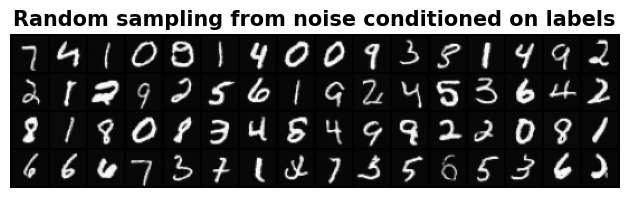

In [28]:
plt.figure(figsize=(12, 2))
plt.imshow(grid.permute(1, 2, 0), cmap='gray')
plt.axis(False)
plt.title('Random sampling from noise conditioned on labels', fontsize=15, fontweight='bold');